In [1]:
import os
import json

from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import torch


from bigram_estimator import getWordDict, getNgramDict, pHat
from generate_watermark import load_model, generate
from likelihood_ratio_test import L_Gw

/Users/wayne/miniconda3/envs/lm-watermarking1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = Namespace()

arg_dict = {
    'run_gradio': False, 
    'demo_public': False,
    'model_name_or_path': 'facebook/opt-125m', 
    # 'model_name_or_path': 'facebook/opt-1.3b', 
    # 'model_name_or_path': 'facebook/opt-2.7b', 
    # 'model_name_or_path': 'facebook/opt-6.7b',
    # 'model_name_or_path': 'facebook/opt-13b',
    # 'load_fp16' : True,
    'load_fp16' : False,
    'prompt_max_length': None, 
    'max_new_tokens': 200, 
    'generation_seed': 123, 
    'use_sampling': True, 
    'n_beams': 1, 
    'sampling_temp': 0.7, 
    
    # 'use_gpu': True, 
    'use_gpu': False, 
    'seeding_scheme': 'simple_1', 
    'gamma': 0.25, 
    'delta': 2.0, 
    'normalizers': '', 
    'ignore_repeated_bigrams': False, 
    'detection_z_threshold': 4.0, 
    'select_green_tokens': True,
    'skip_model_load': False,
    'seed_separately': True,
}

args.__dict__.update(arg_dict)

args.is_seq2seq_model = any([(model_type in args.model_name_or_path) for model_type in ["t5","T0"]])
args.is_decoder_only_model = any([(model_type in args.model_name_or_path) for model_type in ["gpt","opt","bloom"]])


In [3]:
model, tokenizer, device = load_model(args)


In [4]:
times = 2 #1000
tokd_input, watermark_processor, output, corpus_without_watermark, corpus_with_watermark, _ = generate("",
                                                                    args,
                                                                    model=model,
                                                                    device=device,
                                                                    tokenizer=tokenizer,
                                                                    times=times)

Generating with Namespace(run_gradio=False, demo_public=False, model_name_or_path='facebook/opt-125m', load_fp16=False, prompt_max_length=None, max_new_tokens=200, generation_seed=123, use_sampling=True, n_beams=1, sampling_temp=0.7, use_gpu=False, seeding_scheme='simple_1', gamma=0.25, delta=2.0, normalizers='', ignore_repeated_bigrams=False, detection_z_threshold=4.0, select_green_tokens=True, skip_model_load=False, seed_separately=True, is_seq2seq_model=False, is_decoder_only_model=True)


To load whole corpora. Only use when analysing over larger corpora

In [52]:
path_watermarked = '/data/corpora_with_watermark/'
json_file_names = [filename for filename in os.listdir(path_watermarked) if filename.endswith('.json')]
# print(json_file_names)
corpus_with_watermark = []
for json_file_name in json_file_names:
    with open(os.path.join(path_watermarked, json_file_name)) as json_file:
        foo = json.load(json_file)
    corpus_with_watermark += foo

In [53]:
path_nonwatermarked = '/data/corpora_without_watermark/'
json_file_names = [filename for filename in os.listdir(path_nonwatermarked) if filename.endswith('.json')]
corpus_without_watermark = []
for json_file_name in json_file_names:
    with open(os.path.join(path_nonwatermarked, json_file_name)) as json_file:
        foo = json.load(json_file)
    corpus_without_watermark += foo

In [5]:
word_dict_w = getWordDict(corpus_with_watermark, tokenizer)
n_gram_dict_w = getNgramDict(corpus_with_watermark, tokenizer)

word_dict_nw = getWordDict(corpus_without_watermark, tokenizer)
n_gram_dict_nw = getNgramDict(corpus_without_watermark, tokenizer)

In [6]:
pHat('Ġgot', 'Ġthe', word_dict_w, n_gram_dict_w)
# pHat('The', 'Ġfact', word_dict_nw, n_gram_dict_nw)

0.2727272727272727

## Computing $\sup_{\theta \in \Theta} L(\theta)$

In [7]:
#greenlist_w = watermark_processor._get_greenlist_ids(torch.tensor(tokenizer.encode("hello")).to(device))
#int(tokenizer.vocab.values()

# path_nonwatermarked = '/data/corpora_without_watermark/'
# with open(os.path.join(path_nonwatermarked, 'corpus_without_watermark.json')) as json_file:
#    corpus_without_watermark = json.load(json_file)

# word_dict_nw = getWordDict(corpus_without_watermark)
# n_gram_dict_nw = getNgramDict(corpus_without_watermark)


deltaarr = np.arange(0, 1, 0.1)
# deltaarr
Larr, redsum = L_Gw(deltaarr, 'Ġup', word_dict_nw, n_gram_dict_nw, watermark_processor, tokenizer)
#print(redsum)
# plt.plot(deltaarr, Larr)

In [8]:
Larr

array([  9.48537133,   6.53878539,   3.58473688,   0.62324588,
        -2.34563126,  -5.32180295,  -8.30514415, -11.29549868,
       -14.29268206, -17.29648471])

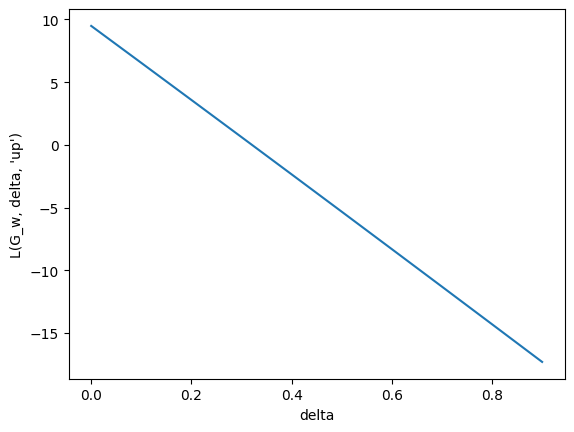

In [9]:
# Larr = L(deltaarr, 'Ġup', word_dict_nw, n_gram_dict_nw, watermark_processor)
plt.plot(deltaarr, Larr)
plt.xlabel("delta")
plt.ylabel("L(G_w, delta, \'up\')")
plt.show()

In [45]:
## L gradient descent

optim = torch.optim.SGD()

tensor([[  113,  1711,    21,   269,  3035,   113,  1437,  1437,    22, 14783,
            38,   218,    75,   216,   932,    59,   930,     8,    38,  3996,
             5,   569,   113,  1437,  1437,    22,   100,   218,    75,   216,
           932,    59,   930,   113,  1437,  1437,    22,  2847,    99,    32,
            47,   608,    19,   110,  1730,  1917,  1437,  1437,    22,   100,
           437,  6908,   120,   106,     7,  3836,   113, 50118,   243,    18,
            67,     5,   275,  2214,    11,     5,  1445,  2642,   328,     2]])
